In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.distributions import normal

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from dataset_lib import CenteredStarsData, trim_psf
from which_device import device
print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [3]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 11
psf = trim_psf(psf, 11)

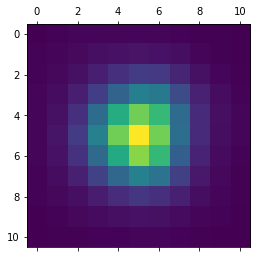

In [4]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [16]:
n_images = 20000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

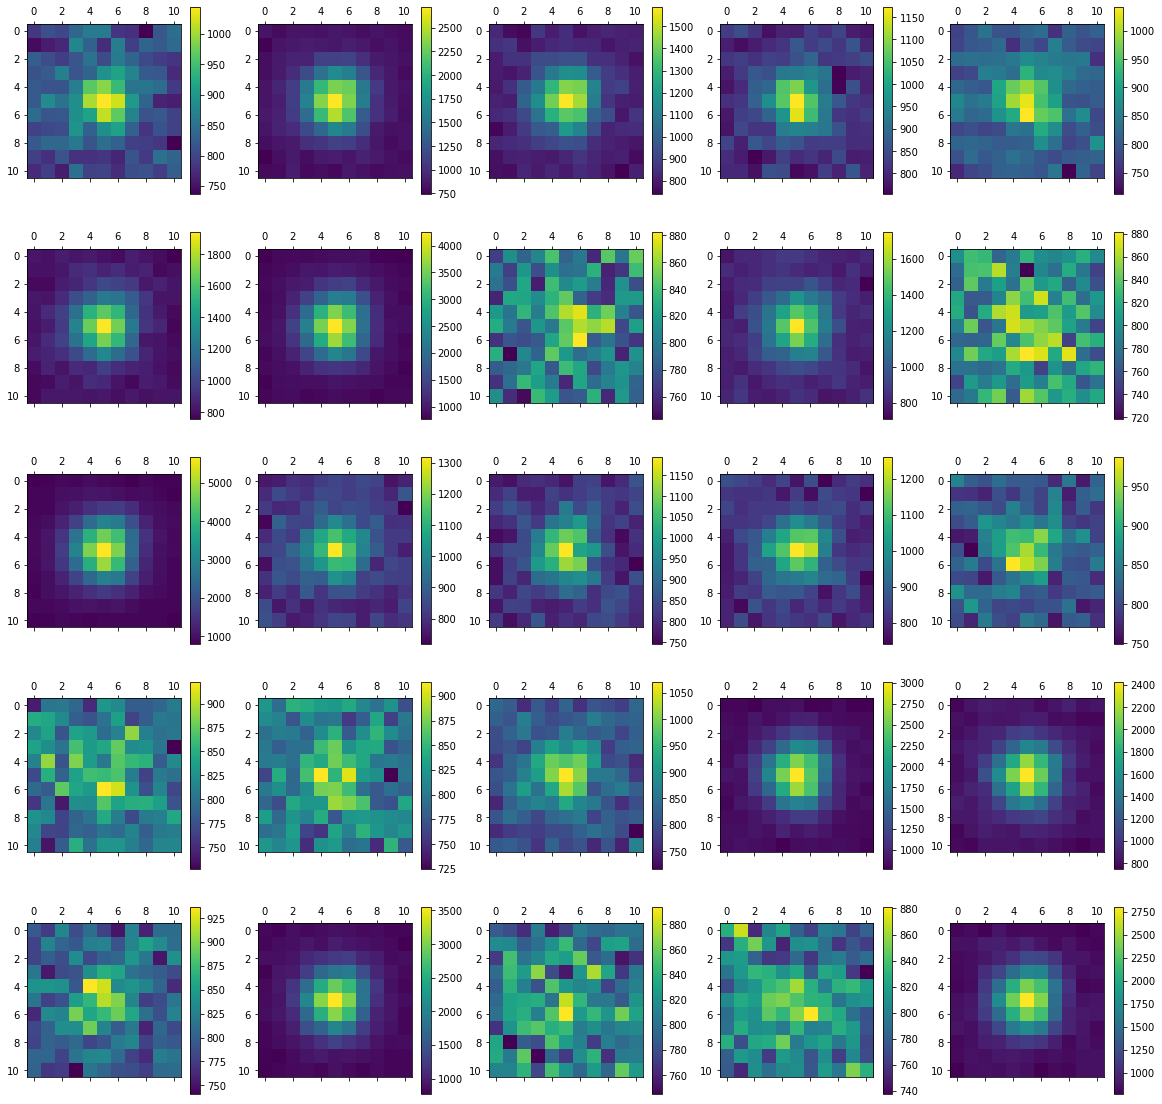

In [17]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25): 
        
    x0 = i // 5
    x1 = i % 5
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [18]:
network = encoder.ImageEncoder(ptile_slen = slen, 
                               # tile slen doesn't matter. 
                               tile_slen = 1).to(device)

In [46]:
def get_var_params(network, images): 
    
    # return a vector of hidden parameters: 
    # this is just a forward pass through the network archetecture, 
    # without all the extra indexing and stuff
    h = network.get_var_params_all(images)
    
    # we just take the first two as our variatoinal mean 
    # and log-variance 
    
    mean = h[:, 0]
    sd = torch.exp(h[:, 1]) * 0.0 + 1.
    
    return mean, sd

# Define dataset

In [28]:
batch_size = 1000
data_loader = DataLoader(star_data, 
                         batch_size=batch_size)

# Define loss

### Sleep phase loss: KL(p, q), with log-normal distribution

In [40]:
def klpq_logspace(network, batch): 
    
    images = batch['image']
    fluxes = batch['flux'].squeeze()
    
    logflux = torch.log(fluxes)
    
    mean, sd = get_var_params(network, images)
    
    norm = normal.Normal(loc = mean, scale = sd)
    
    return - norm.log_prob(logflux)

# Train 

In [41]:
for _, batch in enumerate(data_loader):
    break

In [42]:
# initial loss 
loss = klpq_logspace(network, batch).mean()
print('initial loss: {}'.format(loss))

initial loss: 13.009224891662598


In [43]:
optimizer = optim.Adam(network.parameters())

In [44]:
n_epochs = 60

In [45]:
network.train()
t0 = time.time() 

for epoch in range(n_epochs): 
    
    avg_loss = 0.
    
    for _, batch in enumerate(data_loader):
        loss = klpq_logspace(network, batch).mean()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        avg_loss += loss 
        
    print('epoch [{}]. loss = {}'.format(epoch, avg_loss / len(data_loader)))

print('done. Elapsed {:.03f}sec'.format(time.time() - t0))

epoch [0]. loss = 5.1656694412231445
epoch [1]. loss = 0.9815453886985779
epoch [2]. loss = 0.9338361024856567


KeyboardInterrupt: 

In [35]:
# final loss
network.eval()
loss = klpq_logspace(network, batch).mean()
print('final loss: {}'.format(loss))

final loss: 0.938036322593689


In [36]:
true_fluxes = batch['flux']

means, sd = get_var_params(network, batch['image'])

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

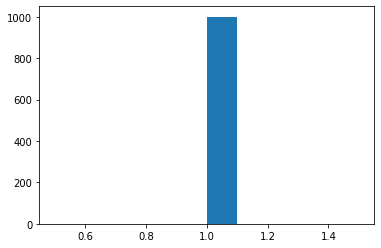

In [37]:
plt.hist(sd.detach().cpu().numpy())

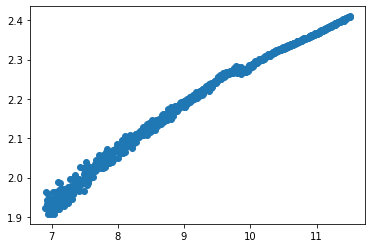

In [38]:
plt.scatter(np.log(true_fluxes.cpu()), 
            np.log(means.detach().cpu()))

In [39]:
true_fluxes.shape

torch.Size([1000, 1])

# Evaluate

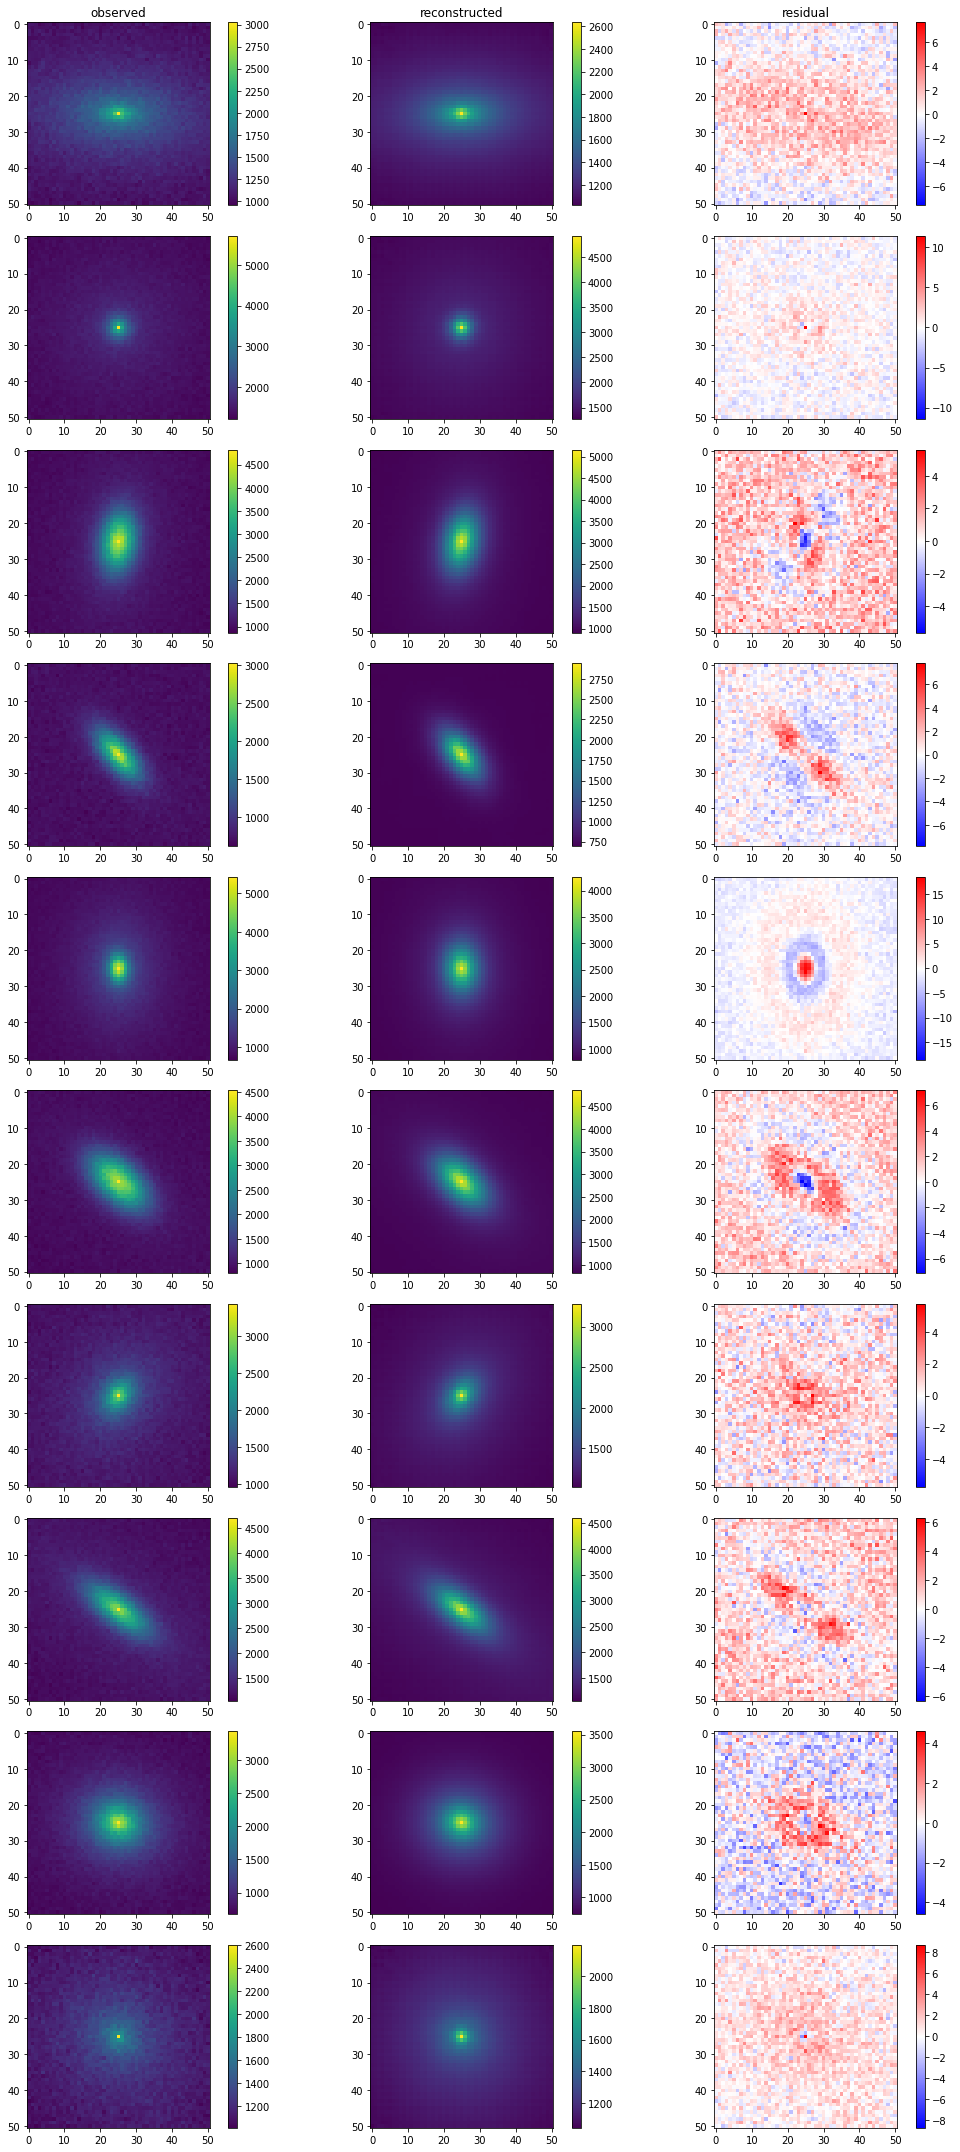

In [12]:
for images in data_loader:
    break

recon_mean = galaxy_vae(images)[0]

fig, ax = plt.subplots(10, 3, figsize=(15, 30))

for i in range(10):
    
    ax1 = ax[i, 0]
    ax2 = ax[i, 1]
    ax3 = ax[i, 2]
    
    # plot image
    im1 = ax1.imshow(images[i, 0].cpu())
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(recon_mean[i, 0].detach().cpu())
    fig.colorbar(im2, ax=ax2)    
    
    x = images[i, 0]
    y = recon_mean[i, 0]
    diff = ((x - y) / torch.sqrt(y)).detach().cpu()
    vmax = diff.abs().max()
    im3 = ax3.imshow(diff, vmax = vmax, vmin = -vmax, cmap = plt.get_cmap('bwr'))
    fig.colorbar(im3, ax = ax3)
    
    if i == 0: 
        ax1.set_title('observed')
        ax2.set_title('reconstructed')
        ax3.set_title('residual')
    
fig.tight_layout()